<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Advanced Interval Plotting
Author(s): Paul Miles | Date Created: July 18, 2019

For the purpose of this example we will consider the Monod model demonstrated [here](Monod.ipynb).

In [1]:
import numpy as np
import scipy.optimize
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0


In [2]:
def model(q, data):
    x = data.xdata[0]
    a, b = q
    y = a*x/(b + x)
    return y.reshape(y.size,)

def ssfun(q, data):
    yd = data.ydata[0]
    ym = model(q, data).reshape(yd.shape)
    return ((yd - ym)**2).sum()

In [3]:
from pymcmcstat.MCMC import DataStructure
data = DataStructure()
# data structure
x = np.array([28, 55, 83, 110, 138, 225, 375])  # (mg / L COD)
y = np.array([0.053, 0.060, 0.112, 0.105, 0.099, 0.122, 0.125]) # (1 / h)
data.add_data_set(x, y)
# Calculate initial covariance matrix
def residuals(q):
    yd = data.ydata[0]
    ym = model(q, data)
    res = yd - ym.reshape(yd.shape)
    return res.reshape(res.size, )

ls0 = scipy.optimize.least_squares(residuals, [0.15, 100],
                                  verbose=2, max_nfev=100)
theta0 = ls0.x
n = data.n[0]  # number of data points in model
p = len(theta0)  # number of model parameters (dof)
ssmin = ssfun(theta0, data)  # calculate the sum-of-squares error
mse = ssmin/(n-p)  # estimate for the error variance
J = np.array([[x/(theta0[1]+x)], [-theta0[0]*x/(theta0[1]+x)**2]])
J = J.transpose()
J = J.reshape(n, p)
tcov = np.linalg.inv(np.dot(J.transpose(), J))*mse

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8012e-03                                    6.53e-02    
       1              3         5.7019e-04      1.23e-03       2.18e+01       5.81e-03    
       2              4         4.2786e-04      1.42e-04       3.68e+01       3.09e-03    
       3              5         4.0841e-04      1.95e-05       7.61e+00       3.51e-04    
       4              6         4.0839e-04      2.00e-08       7.33e-02       1.57e-07    
       5              7         4.0839e-04      5.23e-12       4.69e-03       1.56e-10    
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 1.8012e-03, final cost 4.0839e-04, first-order optimality 1.56e-10.


In [4]:
# Initialize MCMC object
mcstat = MCMC()
mcstat.data = data
# Define model parameters, simulation options, and model settings.
mcstat.parameters.add_model_parameter(
    name='$\mu_{max}$',
    theta0=theta0[0],
    minimum=0)
mcstat.parameters.add_model_parameter(
    name='$K_x$',
    theta0=theta0[1],
    minimum=0)
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5.0e3),
    updatesigma=True,
    qcov=tcov)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,
    sigma2=0.01**2)
# Run simulation
mcstat.run_simulation()
# Extract results and print statistics
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
mcstat.chainstats(chain, results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
$\mu_{max}$:      0.15 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
     $K_x$:     49.05 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 1.0 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
$\mu_{max}$:     0.1544     0.0220     0.0008    10.8093     0.9298
$K_x$     :    61.7267    29.0816     1.2178    15.6448     0.7330
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 32.62%
Stage 2: 49.36%
Net    : 81.98% -> 4099/5000
---------------
Chain provided:
Net    : 81.98% -> 4099/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


# Plot Credible/Prediction Intervals
Define function for generating intervals, setup calculations, and generate.

In [5]:
from pymcmcstat.propagation import calculate_intervals

intervals = calculate_intervals(chain, results, data, model,
                               s2chain=s2chain, nsample=500, waitbar=True)
def format_plot():
    plt.xlabel('x (mg/L COD)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel('y (1/h)', fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Predictive envelopes of the model', fontsize=20);

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

# Plotting
Required inputs:
- `intervals`: Output from `calculate_intervals`
- `time`: Independent x-axis values

Available inputs: (Defaults in Parantheses)
- `ydata`: Observations, expect 1-D array if defined. (`None`)
- `xdata`: Independent values corresponding to observations. This is required if the observations do not align with your times of generating the model response. (`None`)
- `limits`: Quantile limits that correspond to percentage size of desired intervals. Note, this is the default limits, but specific limits can be defined using the ciset and piset dictionaries.
- `adddata`: Flag to include data.  (`False`, - if `ydata` is not `None`, then `True`)
- `addmodel`: Flag to include median model response. (`True`)
- `addlegend`: Flag to include legend. (`True`)
- `addcredible`: Flag to include credible intervals. (`True`)
- `addprediction`: Flag to include prediction intervals. (`True`)
- `fig`: Handle of previously created figure object. (`None`)
- `figsize`: (width, height) in inches. (`None`)
- `legloc`: Legend location - matplotlib help for details. (`'upper left'`)
- `ciset`: Settings for credible intervals. (`None` - see below)
- `piset`: Settings for prediction intervals. (`None` - see below)
- `return_settings`: Flag to return ciset and piset along with fig and ax. (`False`)
- `model_display`: Model display settings. (See below)
- `data_display`: Data display settings. (See below)
- `interval_display`: Interval display settings. (See below)

Default general display options:
- `interval_display = {'linestyle': ':', 'linewidth': 1, 'alpha': 0.5, 'edgecolor': 'k'}`
- `model_display = {'linestyle': '-', 'marker': '', 'color': 'r', 'linewidth': 2, 'markersize': 5, 'label': 'model', 'alpha': 1.0}`
- `data_display = {'linestyle': '', 'marker': '.', 'color': 'b', 'linewidth': 1, 'markersize': 5, 'label': 'data', 'alpha': 1.0}`

Display options specify to credible and prediction intervals:
- `limits`: This should be a list of numbers between 0 and 100, e.g., limits=[50, 90] will result in 50% and 90% intervals.
- `cmap`: The program is designed to “try” to choose colors that are visually distinct. The user can specify the colormap to choose from.
- `colors`: The user can specify the color they would like for each interval in a list, e.g., [‘r’, ‘g’, ‘b’]. This list should have the same number of elements as limits or the code will revert back to its default behavior.

## Case 1: Use default settings

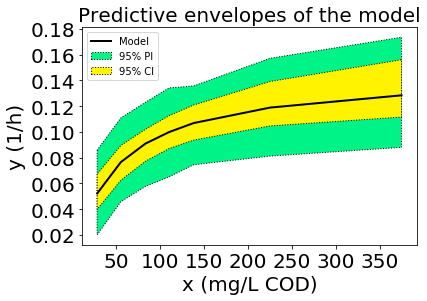

In [15]:
from pymcmcstat.propagation import plot_intervals
plot_intervals(intervals, data.xdata[0])
format_plot()

## Case 2: Include Data and Adjust Appearance

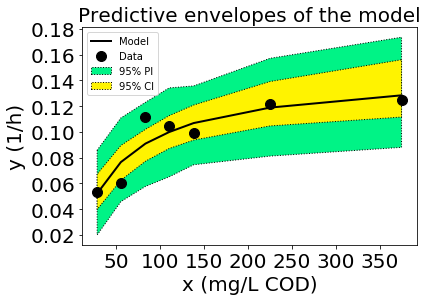

In [16]:
data_display = dict(
    marker='o',
    color='k',
    markersize=10)
plot_intervals(intervals, data.xdata[0], data.ydata[0],
              data_display=data_display, adddata=True)
format_plot()

## Case 3: Adjust Appearance of Model

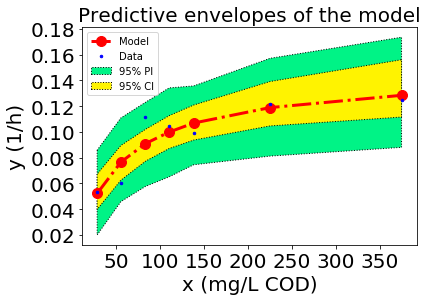

In [17]:
model_display = dict(
    linestyle='-.',
    linewidth=3,
    color='r',
    marker='o',
    markersize=10)
plot_intervals(intervals, data.xdata[0], data.ydata[0],
              model_display=model_display, adddata=True)
format_plot()

## Case 3: Adjust Appearance of Intervals

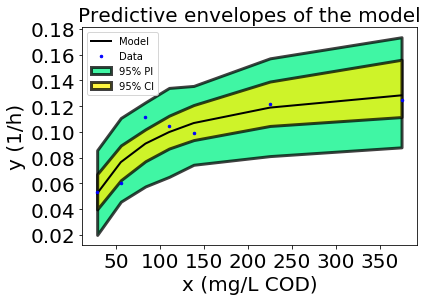

In [18]:
interval_display = dict(
    linestyle='-',
    linewidth=3,
    alpha=0.75,
    edgecolor='k')
plot_intervals(intervals, data.xdata[0], data.ydata[0],
              interval_display=interval_display, adddata=True)
format_plot()

# Case 4: Specify Credible Intervals Size and Colors
- Turn off prediction intervals
- Specify colors using color map or directly
- Adjust legend location

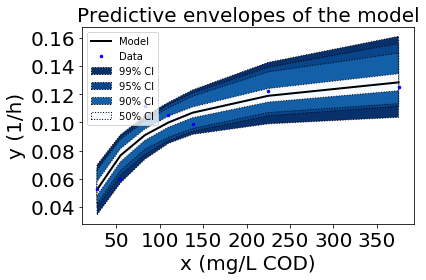

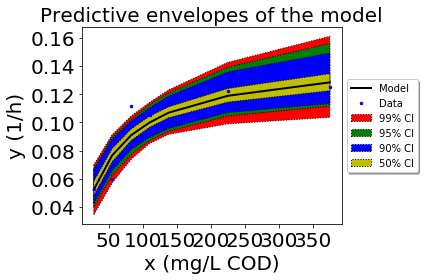

In [30]:
from matplotlib import cm
ciset = dict(
    limits=[50, 90, 95, 99],
    cmap=cm.Blues)
f, ax = plot_intervals(intervals, data.xdata[0], data.ydata[0], addprediction=False,
              adddata=True, ciset=ciset)
format_plot()
f.tight_layout()

ciset = dict(
    limits=[50, 90, 95, 99],
    cmap=cm.Blues,
    colors=['r', 'g', 'b', 'y'])
f, ax = plot_intervals(intervals, data.xdata[0], data.ydata[0], addprediction=False,
              adddata=True, ciset=ciset)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
format_plot()
f.tight_layout()